# Target :
# Set up a basic skeleton model, train it for 15 epochs to achieve 99.4 test accuracy 

# Results :
# a.) Paramteres : 19.6k
# b.) Best train accuracy : 99.67
# c.) Best test accuracy :   99.02

# Analysis : 
# a.) Model is overfitting. Requires regularization.
# b.) Number of parameters are large

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                     #transforms.Resize((28, 28)),
                                     #transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                     #transforms.RandomRotation((-7.0, 7.0)),
                                     #transforms.RandomGrayscale(p=0.01),        
                                     #transforms.ColorJitter(brightness=0.2, contrast=0.2),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.1307,), (0.3081,))
                                       # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=16, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1,bias=False),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1,bias=False),
            nn.ReLU(),
            nn.MaxPool2d(4, 4),

        )    
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 50, 3, padding=1,bias=False),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

        )
      
        self.fc = nn.Sequential(
            nn.Linear(50, 10,bias=False),
        )                
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
      
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)
        return x

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             144
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           4,608
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 3, 3]               0
            Conv2d-7             [-1, 50, 3, 3]          14,400
              ReLU-8             [-1, 50, 3, 3]               0
         MaxPool2d-9             [-1, 50, 1, 1]               0
           Linear-10                   [-1, 10]             500
Total params: 19,652
Trainable params: 19,652
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.32
Params size (MB): 0.07
Estimate

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.0002)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.07343117892742157 Batch_id=937 Accuracy=91.53: 100%|███████████████████████████████████████████████████████████| 938/938 [00:05<00:00, 168.63it/s]



Test set: Average loss: 0.1020, Accuracy: 9652/10000 (96.52%)

EPOCH: 1


Loss=0.014901787042617798 Batch_id=937 Accuracy=97.99: 100%|██████████████████████████████████████████████████████████| 938/938 [00:05<00:00, 166.37it/s]



Test set: Average loss: 0.0476, Accuracy: 9845/10000 (98.45%)

EPOCH: 2


Loss=0.023326203227043152 Batch_id=937 Accuracy=98.58: 100%|██████████████████████████████████████████████████████████| 938/938 [00:06<00:00, 155.81it/s]



Test set: Average loss: 0.0440, Accuracy: 9862/10000 (98.62%)

EPOCH: 3


Loss=0.0045344531536102295 Batch_id=937 Accuracy=98.78: 100%|█████████████████████████████████████████████████████████| 938/938 [00:06<00:00, 153.08it/s]



Test set: Average loss: 0.0392, Accuracy: 9876/10000 (98.76%)

EPOCH: 4


Loss=0.05312652885913849 Batch_id=937 Accuracy=98.97: 100%|███████████████████████████████████████████████████████████| 938/938 [00:05<00:00, 163.85it/s]



Test set: Average loss: 0.0398, Accuracy: 9863/10000 (98.63%)

EPOCH: 5


Loss=0.00010567903518676758 Batch_id=937 Accuracy=99.08: 100%|████████████████████████████████████████████████████████| 938/938 [00:05<00:00, 163.85it/s]



Test set: Average loss: 0.0362, Accuracy: 9886/10000 (98.86%)

EPOCH: 6


Loss=0.0009036660194396973 Batch_id=937 Accuracy=99.20: 100%|█████████████████████████████████████████████████████████| 938/938 [00:05<00:00, 168.88it/s]



Test set: Average loss: 0.0408, Accuracy: 9872/10000 (98.72%)

EPOCH: 7


Loss=0.02542009949684143 Batch_id=937 Accuracy=99.31: 100%|███████████████████████████████████████████████████████████| 938/938 [00:06<00:00, 144.69it/s]



Test set: Average loss: 0.0421, Accuracy: 9866/10000 (98.66%)

EPOCH: 8


Loss=0.003142744302749634 Batch_id=937 Accuracy=99.41: 100%|██████████████████████████████████████████████████████████| 938/938 [00:05<00:00, 160.34it/s]



Test set: Average loss: 0.0319, Accuracy: 9902/10000 (99.02%)

EPOCH: 9


Loss=9.906291961669922e-05 Batch_id=937 Accuracy=99.47: 100%|█████████████████████████████████████████████████████████| 938/938 [00:05<00:00, 168.93it/s]



Test set: Average loss: 0.0410, Accuracy: 9886/10000 (98.86%)

EPOCH: 10


Loss=0.058576956391334534 Batch_id=937 Accuracy=99.51: 100%|██████████████████████████████████████████████████████████| 938/938 [00:05<00:00, 166.73it/s]



Test set: Average loss: 0.0364, Accuracy: 9889/10000 (98.89%)

EPOCH: 11


Loss=0.05037340521812439 Batch_id=937 Accuracy=99.59: 100%|███████████████████████████████████████████████████████████| 938/938 [00:05<00:00, 165.56it/s]



Test set: Average loss: 0.0349, Accuracy: 9887/10000 (98.87%)

EPOCH: 12


Loss=0.10856495797634125 Batch_id=937 Accuracy=99.59: 100%|███████████████████████████████████████████████████████████| 938/938 [00:06<00:00, 151.10it/s]



Test set: Average loss: 0.0456, Accuracy: 9880/10000 (98.80%)

EPOCH: 13


Loss=0.00035750865936279297 Batch_id=937 Accuracy=99.67: 100%|████████████████████████████████████████████████████████| 938/938 [00:05<00:00, 160.45it/s]



Test set: Average loss: 0.0400, Accuracy: 9885/10000 (98.85%)

EPOCH: 14


Loss=0.08320215344429016 Batch_id=937 Accuracy=99.66: 100%|███████████████████████████████████████████████████████████| 938/938 [00:05<00:00, 172.55it/s]



Test set: Average loss: 0.0359, Accuracy: 9902/10000 (99.02%)



Text(0.5, 1.0, 'Test Accuracy')

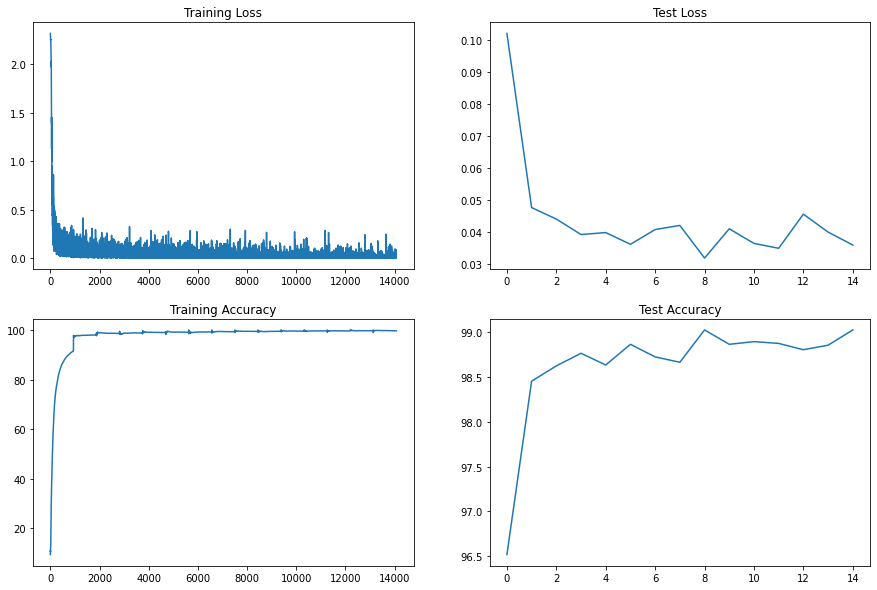

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

train_losses_cpu = []
for loss in train_losses:
    train_losses_cpu.append(loss.cpu().data.numpy())  

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses_cpu)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")